# <center> Introduction to U-Net (W7S1)

### We have covered:

* Project Introduction
* Introduction to Python basics, NumPy, Matplotlib
* Neural Networks Theory
* Logistic Regression, Neural network implementation using NumPy
* Theroretical Introduction of Convolution Neural Networks
* CNN implementation in TensorFlow and keras
* Image Processing with OpenCV
* Exploring Dataset and image data labelling using labelme
* Theoretical Image Segmentation and Transpose Convolution

### In today's session, we will learn - 

* Theoretical understanding of UNet
* Code Implementation of UNet












## What is UNet?

UNet, evolved from the traditional convolutional neural network, was first designed and applied in 2015 to process biomedical images. As a general convolutional neural network focuses its task on image classification, where input is an image and output is one label, but in biomedical cases, it requires us not only to distinguish whether there is a disease, but also to localise the area of abnormality.

UNet is dedicated to solving this problem. 

## *The reason it is able to localise and distinguish borders is by doing classification on every pixel, so the input and output share the same size.*



### For example, for an input image of size 2x2:

> [[23, 89],

>  [1, 23]]

 ### the output will be pixel based classification of size 2x2 only - 

> [[1, 2],

>   [0, 1]]

#### But the original UNet architecture does not the follow this constraint of same size.





## The basic foundation of network looks like - 
 *The name **U-Net** is just because of it's U-shaped architecture.*



![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png)

## Major tasks that can be achieved by UNet 

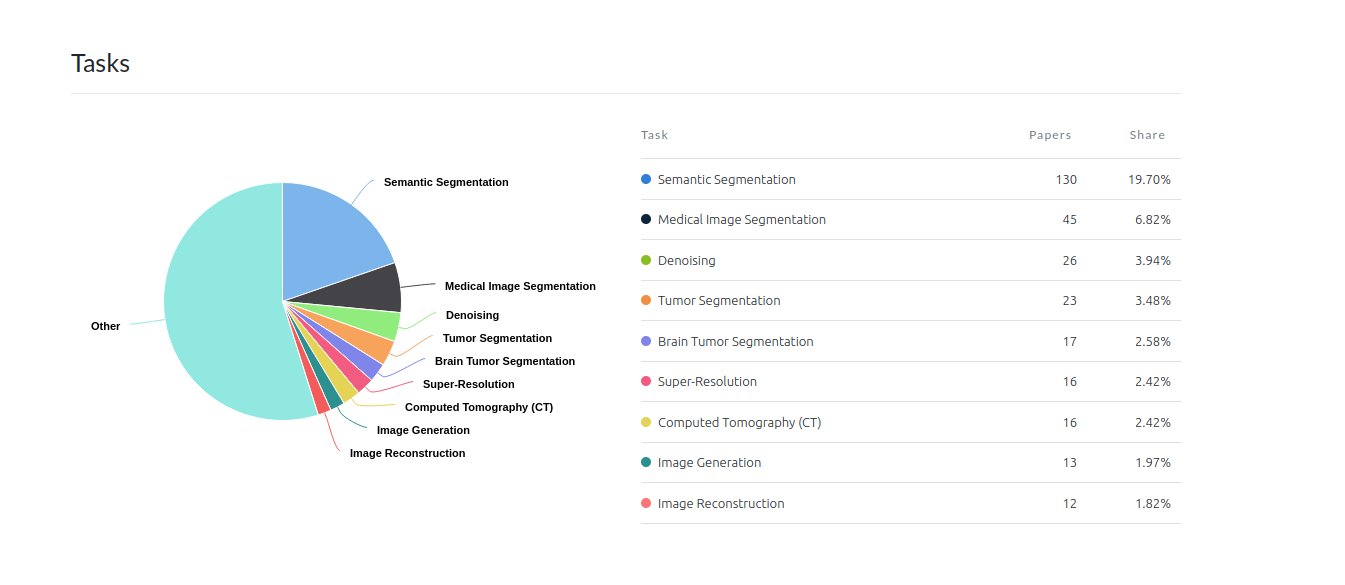

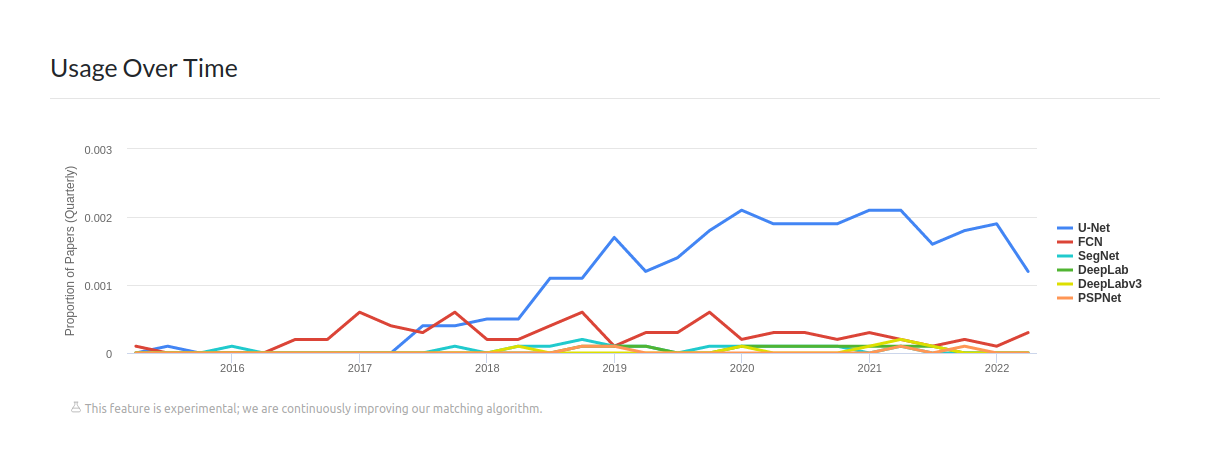

## Step by Step implementation of original UNet architecture

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from keras.models import Model

## Building the contraction part 

It consists 4 blocks and each block contains 4 layers 

conv_layer1 -> conv_layer2 -> max_pooling -> dropout(optional)


![](https://miro.medium.com/max/212/1*xW5JGavuJAxwMsJRZs_0Rg.png)

In [ ]:

# starting with our original input size of (572, 572, 1)

input_layer = Input((572, 572, 1))

# block 1
# 572, 572, 1 -> 284, 284, 64
conv1 = Conv2D(64, (3, 3), activation="relu", padding="valid")(input_layer)
print(conv1.shape)
conv1 = Conv2D(64, (3, 3), activation="relu", padding="valid")(conv1)
print(conv1.shape)
pool1 = MaxPooling2D((2, 2))(conv1)
print(pool1.shape)
pool1 = Dropout(0.25)(pool1)


print("block1 output shape: ", pool1.shape)

(None, 570, 570, 64)
(None, 568, 568, 64)
(None, 284, 284, 64)
block1 output shape:  (None, 284, 284, 64)


![](https://miro.medium.com/max/384/1*yGu1oXPeqEvbKRuWL0z3Dw.png)


To allow a seamless tiling of the output segmentation map, it
is important to select the input tile size such that all 2x2 max-pooling operations are applied to a layer with an even x- and y-size.

In [ ]:
# 284, 284, 64 -> 140, 140, 128
conv2 = Conv2D(128, (3, 3), activation="relu", padding="valid")(pool1)
conv2 = Conv2D(128, (3, 3), activation="relu", padding="valid")(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)
pool2 = Dropout(0.5)(pool2)
print("block2 output shape:", pool2.shape)

# 140, 140, 128 -> 68, 68, 256
conv3 = Conv2D(256, (3, 3), activation="relu", padding="valid")(pool2)
conv3 = Conv2D(256, (3, 3), activation="relu", padding="valid")(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)
pool3 = Dropout(0.5)(pool3)
print("block3 output shape:", pool3.shape)

# 68, 68, 256 -> 32, 32, 512
conv4 = Conv2D(512, (3, 3), activation="relu", padding="valid")(pool3)
conv4 = Conv2D(512, (3, 3), activation="relu", padding="valid")(conv4)
pool4 = MaxPooling2D((2, 2))(conv4)
pool4 = Dropout(0.5)(pool4)
print("block4 output shape:", pool4.shape)

block2 output shape: (None, 140, 140, 128)
block3 output shape: (None, 68, 68, 256)
block4 output shape: (None, 32, 32, 512)


## Middle part
![](https://miro.medium.com/max/312/1*0973DDf8V7UrgqzuLBiyaQ.png)

In [ ]:
# Middle block 
# 32, 32, 512 -> 28, 28, 1024
convm = Conv2D(1024, (3, 3), activation="relu", padding="valid")(pool4)
convm = Conv2D(1024, (3, 3), activation="relu", padding="valid")(convm)
print("middle block output shape:", convm.shape)

middle block output shape: (None, 28, 28, 1024)


## Expansion Part

In this part, we will upsample the image using transpose layers and concatenation. 

> The network works with very few training images and yields more precise segmentations; The main idea is to supplement a usual contracting network by successive layers, where pooling operators are replaced by upsampling operators.

#### Skip Connections
> Hence, these layers increase the resolution of the output. In order to localize, high resolution features from the contracting path are combined with the upsampled output and it is called **skip connections**. A successive convolution layer can then learn to assemble a more precise output based on this information.

A more elaborative explanation on why we are using skip connections: https://github.com/christianversloot/machine-learning-articles/blob/main/u-net-a-step-by-step-introduction.md#the-need-for-skip-connections


### This is how our upcoming blocks will look like 

conv_2d_transpose -> concatenate -> conv_layer1 -> conv_layer2

![](https://miro.medium.com/max/700/1*f7YOaE4TWubwaFF7Z1fzNw.png)

###  Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. 

### The cropping is necessary due to the loss of border pixels in every convolution


![](https://miro.medium.com/max/570/1*-2FyAsc71aCXiEHTkVnI7Q.png)

In [ ]:
# 28, 28, 1024 -> 56, 56, 1024 -> 52, 52, 512
deconv4 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding="same")(convm)

# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Cropping2D 
conv4 = tf.keras.layers.Cropping2D(cropping=((4, 4), (4, 4)))(conv4) # cropping 4 pixels from each side to make both layers size equal

# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate
uconv4 = concatenate([deconv4, conv4])
uconv4 = Dropout(0.5)(uconv4)
uconv4 = Conv2D(512, (3, 3), activation="relu", padding="valid")(uconv4)
uconv4 = Conv2D(512, (3, 3), activation="relu", padding="valid")(uconv4)

print(uconv4.shape)


(None, 52, 52, 512)


In [ ]:
# 52, 52, 512 -> 104, 104, 512 -> 100, 100, 256
deconv3 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same")(uconv4)
conv3 = tf.keras.layers.Cropping2D(cropping=((16, 16), (16, 16)))(conv3)
uconv3 = concatenate([deconv3, conv3])
uconv3 = Dropout(0.5)(uconv3)
uconv3 = Conv2D(256, (3, 3), activation="relu", padding="valid")(uconv3)
uconv3 = Conv2D(256, (3, 3), activation="relu", padding="valid")(uconv3)
print(uconv3.shape)

# 100, 100, 256 -> 200, 200, 256 -> 196, 196, 128
deconv2 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(uconv3)
conv2 = tf.keras.layers.Cropping2D(cropping=((40, 40), (40, 40)))(conv2)
uconv2 = concatenate([deconv2, conv2])
uconv2 = Dropout(0.5)(uconv2)
uconv2 = Conv2D(128, (3, 3), activation="relu", padding="valid")(uconv2)
uconv2 = Conv2D(128, (3, 3), activation="relu", padding="valid")(uconv2)
print(uconv2.shape)

# 196, 196, 128 -> 392, 392, 128 -> 388, 388, 64
deconv1 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(uconv2)
conv1 = tf.keras.layers.Cropping2D(cropping=((88, 88), (88, 88)))(conv1)
uconv1 = concatenate([deconv1, conv1])
uconv1 = Dropout(0.5)(uconv1)
uconv1 = Conv2D(64, (3, 3), activation="relu", padding="valid")(uconv1)
uconv1 = Conv2D(64, (3, 3), activation="relu", padding="valid")(uconv1)
print(uconv1.shape)

# 388, 388, 64 -> 388, 388, 2
output_layer = Conv2D(filters=2, kernel_size=(1,1), padding="valid", use_bias=True, activation = "relu")(uconv1)
print(output_layer.shape)


model = Model(inputs=[input_layer], outputs=[output_layer],  name="U-Net")


(None, 100, 100, 256)
(None, 196, 196, 128)
(None, 388, 388, 64)
(None, 388, 388, 2)


In [ ]:
print(model.summary())

References: 

1. [“A guide to convolution arithmetic for deep learning"](https://arxiv.org/pdf/1603.07285.pdf)

2. Original UNet paper (highly recommended: https://arxiv.org/pdf/1505.04597.pdf

3. How to use cropping layer with keras: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-cropping-layers-with-keras.md

4. More in-depth guide to UNet: https://github.com/christianversloot/machine-learning-articles/blob/main/u-net-a-step-by-step-introduction.md

## In this session we covered and in-depth look at UNet architecture. 

## Next session, we will learn how to train and generate outputs from UNet based model. 

# Time to practice some questions!

Q-1 What makes the UNet mode so popular and different from other convolutional neural network?

Q-2 What are skip connections?

Q-3 Write all neccessary libraries used to nuild UNet model from scratch.

Q-4 Will layer expansion in the last layer affect performance of unet? If yes, then how does it affects? Also is there any limit to adding number of layers?

# Thank you for completing the notebook!